In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

C:\Users\edufe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Abre os dados

In [2]:
#Verifica os dados no diretorio

Data = os.listdir("../../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]


Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]

#Monta um dicionario com todos datasets de twites de todas as pessoas
Alvo = NoticiasPolitica


AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [3]:
label_encoder = LabelEncoder()

label_encoder.fit(AllData.Pessoa)
AllData['Pessoa_id'] = label_encoder.transform(AllData.Pessoa)

In [4]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id
33435,folha_mercado,2019-02-17 17:57:02,robô que monitora despesas de deputados é bloq...,9,22,1,8
30739,UOLEconomia,2019-01-25 21:31:50,vale dona das barragens rompidas quebrou recor...,2,14,1,6
26850,EstadaoEconomia,2018-04-18 14:57:00,venda de subsidiárias da eletrobrás deve ser a...,3,0,1,0
11249,EstadaoPolitica,2018-10-15 16:01:00,pt perde 1 3 da representatividade no voto em ...,9,21,1,1
11073,EstadaoPolitica,2018-11-03 14:56:18,kassab coloca general na presidência dos corre...,5,18,1,1


In [5]:
document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 13.991752676762806.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 30.


In [6]:
smallerthen4 = document_lengths <= 5

for i in range(len(document_lengths)):
    if smallerthen4[i]:
        AllData = AllData.drop(i)

document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(AllData)

In [9]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Texto))
    df['tokenized_text'] = list(df.tokenized_text)

lda_get_good_tokens(AllData)

In [10]:
print(nltk.corpus.stopwords.words('portuguese')[0:20])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as']


In [11]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('portuguese')[0:20]
    
    del(stopwords[stopwords.index("não")])
    ManualStop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi",
                  "’", "‘", "”", "“", "r", ",", ".", "…", "diz", "à", "ao"]
    Numbers = list(range(10))
    stopwords = stopwords + ManualStop + Numbers
    
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(AllData)

In [12]:
dictionary = Dictionary(documents=AllData.stopwords_removed.values)

print("Found {} words.".format(len(dictionary.values())))

Found 29532 words.


In [13]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 12050 words.


In [14]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stopwords_removed))
    
document_to_bow(AllData)

In [15]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    document_to_bow(df)

In [16]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow
23668,conexaopolitica,2019-02-09 15:27:42,artigos da semana negócios com a china ou negó...,16,104,1,7,[artigos da semana negócios com a china ou neg...,"[[artigos, da, semana, negócios, com, a, china...","[artigos, da, semana, negócios, com, a, china,...","[artigos, semana, negócios, china, ou, negócio...","[(117, 2), (282, 1), (2242, 1), (6790, 2), (97..."
13494,RevistaEpoca,2019-02-27 00:54:53,rt guilherme amado mudança de tom de sérgio ca...,12,0,1,5,[rt guilherme amado mudança de tom de sérgio c...,"[[rt, guilherme, amado, mudança, de, tom, de, ...","[rt, guilherme, amado, mudança, de, tom, de, s...","[guilherme, amado, mudança, tom, sérgio, cabra...","[(228, 1), (445, 1), (446, 1), (1124, 1), (123..."
30413,UOLEconomia,2019-02-13 15:44:08,mpf denuncia neto de figueiredo e filho de fra...,1,5,1,6,[mpf denuncia neto de figueiredo e filho de fr...,"[[mpf, denuncia, neto, de, figueiredo, e, filh...","[mpf, denuncia, neto, de, figueiredo, e, filho...","[mpf, denuncia, neto, figueiredo, filho, franc...","[(65, 1), (472, 1), (1428, 1), (1454, 1), (199..."
23744,conexaopolitica,2019-02-05 19:38:35,política “o governo brasileiro declara guerra ...,139,960,1,7,[política “o governo brasileiro declara guerra...,"[[política, “, o, governo, brasileiro, declara...","[política, “, o, governo, brasileiro, declara,...","[política, governo, brasileiro, declara, guerr...","[(39, 1), (121, 1), (172, 1), (1400, 1), (1544..."
22280,conexaopolitica,2019-04-30 14:00:01,últimas país tem urgência também na área da ju...,122,653,1,7,[últimas país tem urgência também na área da j...,"[[últimas, país, tem, urgência, também, na, ár...","[últimas, país, tem, urgência, também, na, áre...","[últimas, país, tem, urgência, também, área, j...","[(15, 1), (17, 1), (338, 1), (660, 1), (815, 1..."


# Análise de tópicos

In [17]:
corpus = AllData.bow

In [18]:
num_topics = 30
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=11,
                        chunksize=10000,
                        iterations = 5,
                        passes=7,
                        alpha='asymmetric')

In [19]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

AllData['lda_features'] = list(map(lambda doc:
                              document_to_lda_features(LDAmodel, doc),
                              AllData.bow))

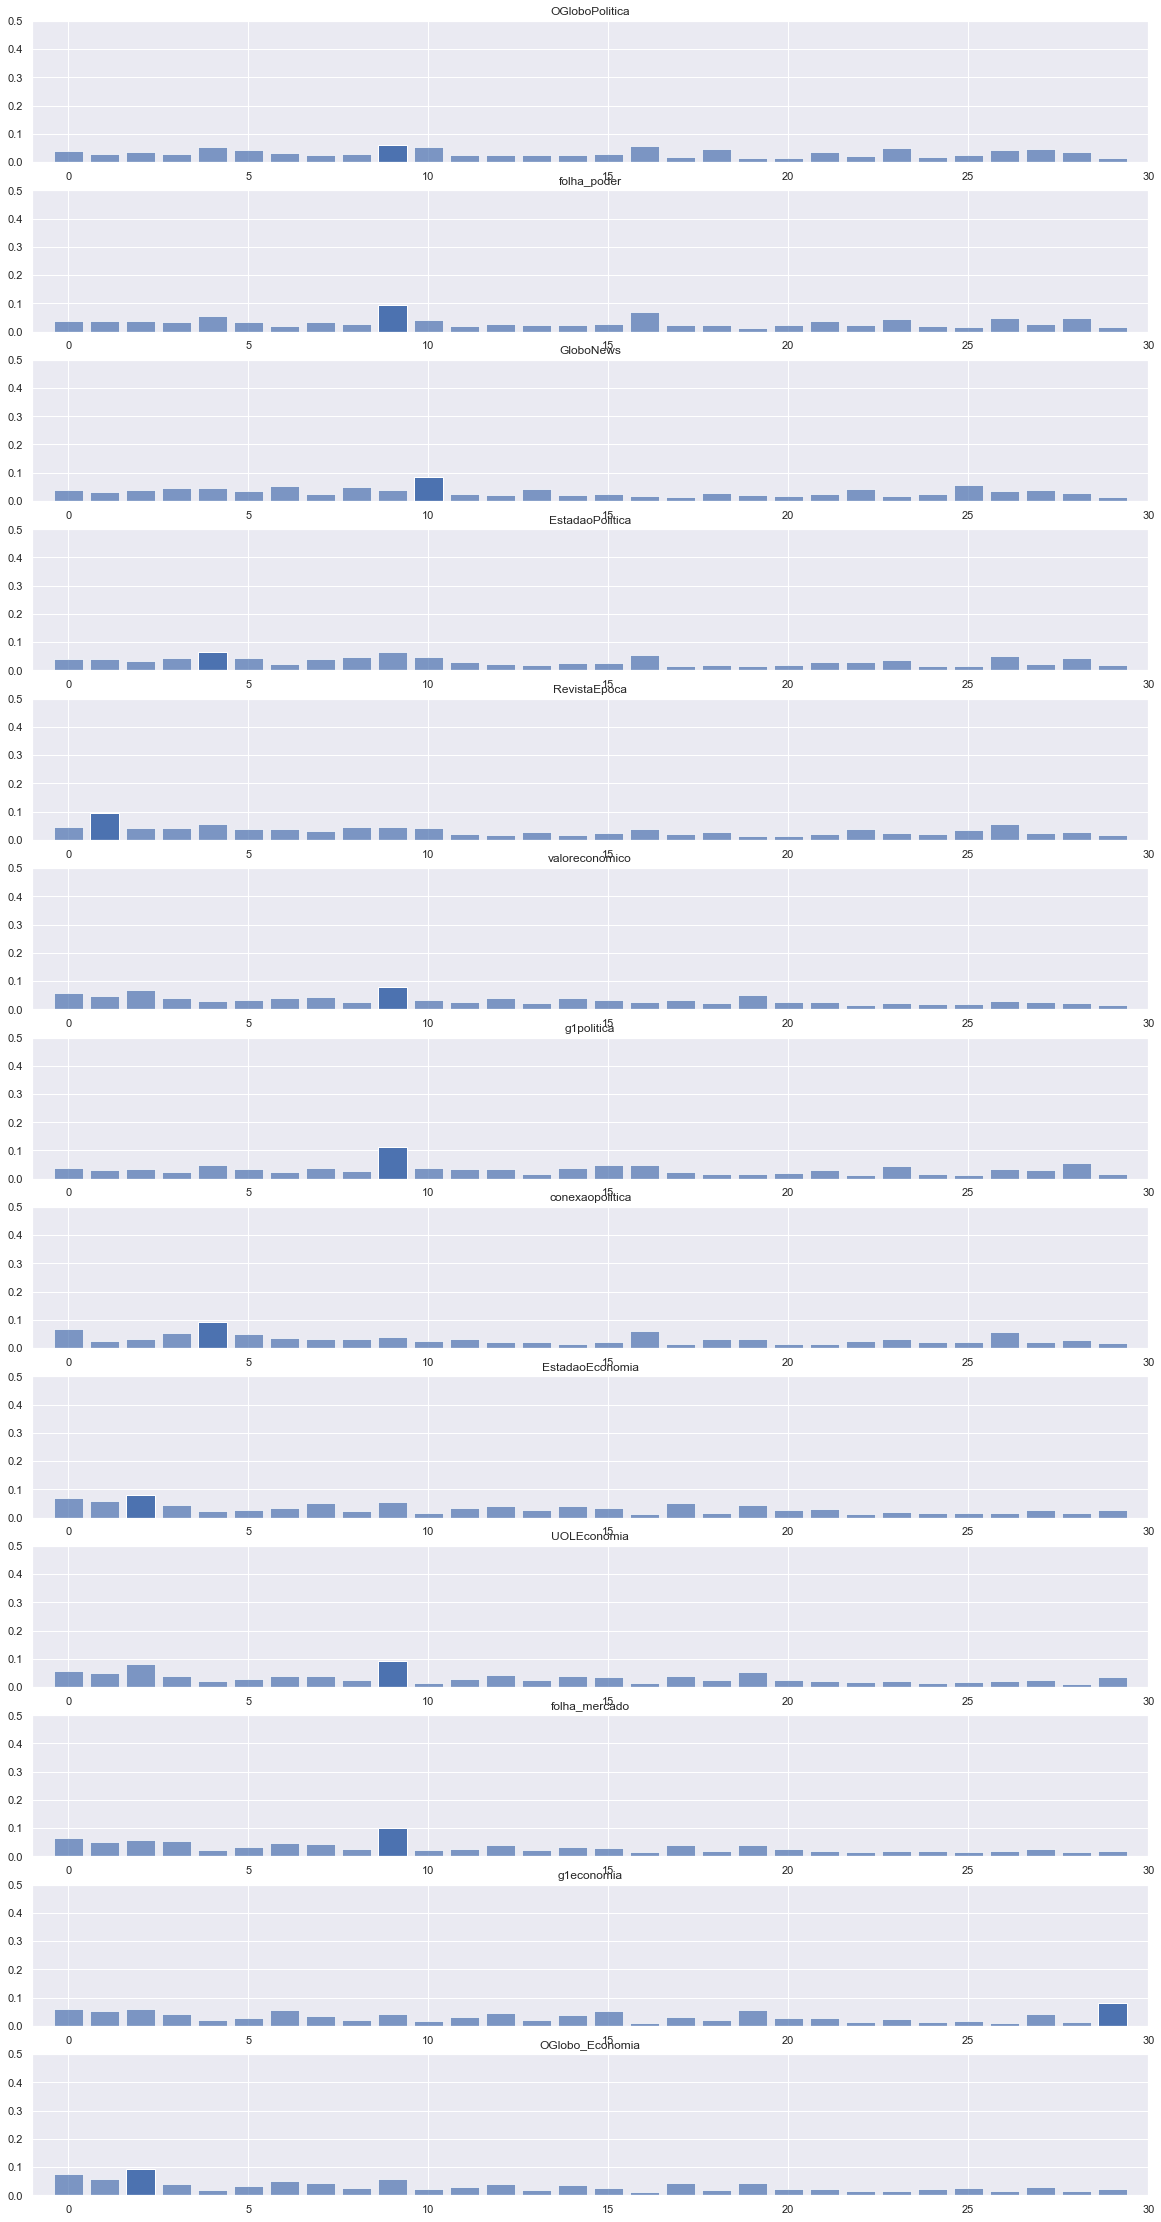

In [20]:
topic_distribution = []
for i in Alvo:
    topic_distribution.append(AllData.loc[AllData.Pessoa == i, 'lda_features'].mean())
    
ax = 0

Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 1

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, topic_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_topics)
    ax.set_ylim(0,0.5)

In [21]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow,lda_features
15958,valoreconomico,2019-04-23 02:15:38,negociação com caminhoneiros inclui ‘amortecer...,6,26,1,12,[negociação com caminhoneiros inclui ‘amortece...,"[[negociação, com, caminhoneiros, inclui, ‘, a...","[negociação, com, caminhoneiros, inclui, ‘, am...","[negociação, caminhoneiros, inclui, amortecer,...","[(1251, 1), (3930, 1), (5452, 1), (5474, 1), (...","[0.5171990990638733, 0.013207854703068733, 0.0..."
23455,conexaopolitica,2019-02-20 10:45:00,mundo onu pede despolitização na ajuda humanit...,22,140,1,7,[mundo onu pede despolitização na ajuda humani...,"[[mundo, onu, pede, despolitização, na, ajuda,...","[mundo, onu, pede, despolitização, na, ajuda, ...","[mundo, onu, pede, despolitização, ajuda, huma...","[(196, 1), (578, 1), (1081, 1), (1325, 1), (13...","[0.013389945030212402, 0.01132118608802557, 0...."
19559,g1politica,2019-04-02 17:10:13,maioria dos líderes defende que mudanças na pr...,3,10,1,11,[maioria dos líderes defende que mudanças na p...,"[[maioria, dos, líderes, defende, que, mudança...","[maioria, dos, líderes, defende, que, mudanças...","[maioria, dos, líderes, defende, mudanças, pre...","[(24, 1), (91, 1), (113, 1), (141, 1), (995, 1...","[0.007209302857518196, 0.006095950957387686, 0..."
29203,UOLEconomia,2019-04-05 18:40:09,maia diz que bpc e rural podem sair da reforma...,0,2,1,6,[maia diz que bpc e rural podem sair da reform...,"[[maia, diz, que, bpc, e, rural, podem, sair, ...","[maia, diz, que, bpc, e, rural, podem, sair, d...","[maia, bpc, rural, podem, sair, reforma, porqu...","[(157, 1), (1154, 1), (1285, 1), (1296, 1), (1...","[0.008520512841641903, 0.007204373367130756, 0..."
24114,conexaopolitica,2019-01-26 15:01:28,brasil itamaraty reitera orientação para que d...,362,1514,1,7,[brasil itamaraty reitera orientação para que ...,"[[brasil, itamaraty, reitera, orientação, para...","[brasil, itamaraty, reitera, orientação, para,...","[brasil, itamaraty, reitera, orientação, diplo...","[(320, 1), (349, 1), (509, 1), (1081, 1), (189...","[0.009372333064675331, 0.14280372858047485, 0...."


In [22]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model."""
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [23]:
from pprint import pprint

print("Looking up top words from top topics")
for x in range(num_topics):
    top_words = get_topic_top_words(LDAmodel, x, nr_top_words=50)
    pprint(f"For topic {x+1}, the top words are:")
    pprint("{0}".format(", ".join(top_words)))
    pprint("")
print("")

Looking up top words from top topics
'For topic 1, the top words are:'
('bolsonaro, vai, governo, brasil, banco, é, sobre, novo, está, não, dos, '
 'após, trump, presidente, juros, central, como, anuncia, país, ano, ações, '
 'bndes, tem, ministro, já, quer, jairbolsonaro, pode, vivo, aviões, contra, '
 'semana, 5, saúde, faz, justiça, mundial, últimas, fim, nova, são, sistema, '
 'reduzir, milhões, mas, 6, nos, deve, dia, sem')
''
'For topic 2, the top words are:'
('guilherme, amado, é, bolsonaro, governo, após, não, sp, brasil, como, vai, '
 'sem, são, das, desemprego, lei, economia, presidente, coluna, 2018, quer, '
 'serviços, mil, temer, congresso, pode, previdência, ano, indústria, '
 'argentina, mas, regras, volta, menor, 12, sobre, reforma, apoio, dias, '
 'fundos, deve, reformas, novo, câmara, fica, ser, avianca, contra, nas, dos')
''
'For topic 3, the top words are:'
('3, dólar, é, sobre, presidente, 0, bolsonaro, alta, mas, fecha, inflação, '
 'bolsa, queda, após, pib, venez

In [24]:
TopicsData = np.array(list(AllData["lda_features"]))
TopicsData = np.transpose(TopicsData)

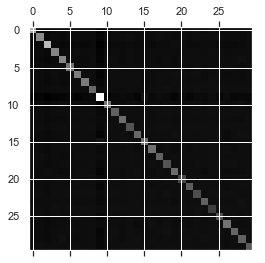

In [25]:
CovMatrix = np.cov(TopicsData)
plt.matshow(CovMatrix, cmap=plt.cm.gray)
plt.show()

## Filtra as ações

In [26]:
Stocks = ["ibov", "ITUB4", "PETR4", "Vale3", "BBDC4", "ABEV3", "BBAS3", "SANB3", "LREN3"]

Cols = {}
for i in range(len(Stocks)):
    Cols[Stocks[i]] = [i*4+i, i*4+i+1, i*4+i+2, i*4+i+3]

In [27]:
Var = 'ibov'
bolsa = pd.read_excel('../../Dados_Bolsa/Twt.xlsx', sheet_name="1h", usecols=Cols[Var],  skiprow=[0])

In [28]:
headers = list(bolsa.keys())
myheaders = [Var, "Price", "Volume", "Ticks"]

for i in range(len(headers)):
    bolsa.rename(columns={headers[i]: myheaders[i]}, inplace=True)
    
bolsa = bolsa.dropna()
bolsa.drop(bolsa.head(1).index,inplace=True)

bolsa = bolsa.reset_index(drop=True)

In [29]:
bolsa.head(5)

,ibov,Price,Volume,Ticks
0,2018-10-08 10:00:00,86283.7,0,119
1,2018-10-08 11:00:00,85686.7,0,120
2,2018-10-08 12:00:00,85408.6,0,120
3,2018-10-08 13:00:00,85267.7,0,120
4,2018-10-08 14:00:00,85686.7,0,120


In [30]:
ibov_len  = len(bolsa[Var])
ibov_len

1110

In [31]:
import datetime

ibov_data_precos = {}
DeadZoneUp = 0.3e-2
DeadZoneDown = 0.6e-2
# célula para identificar os preços de abertura e fechamento de cada dia
for i in range(0, ibov_len):
    data_completa = datetime.datetime.strptime(str(bolsa[Var][i]), '%Y-%m-%d %H:%M:%S')
    preco = bolsa['Price'][i]
    data = data_completa.strftime("%Y-%m-%d")
    if data not in ibov_data_precos:
        ibov_data_precos[data] = {}
        ibov_data_precos[data]['abertura'] = preco
        #caso só tenhamos informação de uma hora dentro de um dia, assumimos esse preco como o de fechamento tbm
        ibov_data_precos[data]['fechamento'] = preco 
        dia_anterior_completo =  data_completa - datetime.timedelta(days=1)
        dia_anterior_data = dia_anterior_completo.strftime("%Y-%m-%d")
        
        if(dia_anterior_data in ibov_data_precos):
            dia_anterior_fechamento = ibov_data_precos[dia_anterior_data]['fechamento']
            
            if(preco > dia_anterior_fechamento + dia_anterior_fechamento*DeadZoneUp):
                ibov_data_precos[data]['variacao'] = 2 #Subiu
            elif (preco < dia_anterior_fechamento - dia_anterior_fechamento*DeadZoneDown):
                ibov_data_precos[data]['variacao'] = 0 #Desceu
            else:
                ibov_data_precos[data]['variacao'] = 1
        else:
            #se não tivermos informações sobre o dia anterior, assumimos que a variacao foi neutra
            ibov_data_precos[data]['variacao'] = 0 
    else:
        if i < (ibov_len - 1):
            data_seguinte = datetime.datetime.strptime(str(bolsa[Var][i+1]), '%Y-%m-%d %H:%M:%S')
            if data_seguinte.date() > data_completa.date():
                ibov_data_precos[data]['fechamento'] = preco

Datesibov = list(ibov_data_precos.keys())
                
for i in range(4):
    print(Datesibov[i], ibov_data_precos[Datesibov[i]])

2018-10-08 {'abertura': 86283.67, 'fechamento': 86083.91, 'variacao': 0}
2018-10-09 {'abertura': 85864.42, 'fechamento': 86087.55, 'variacao': 1}
2018-10-10 {'abertura': 84590.04, 'fechamento': 83679.11, 'variacao': 0}
2018-10-11 {'abertura': 84492.8, 'fechamento': 82921.08, 'variacao': 2}


## Cria os Datasets

In [32]:
OutputData = []
InputData = []
for i in range(len(AllData)):
    data_completa = datetime.datetime.strptime(str(AllData["Data"].iloc[i]), '%Y-%m-%d %H:%M:%S')
    data = data_completa.strftime("%Y-%m-%d")
    if data in list(ibov_data_precos.keys()):
        OutputData.append(ibov_data_precos[data]["variacao"])
        Data = list(AllData['lda_features'].iloc[i])
        Data.append(AllData['Retweets'].iloc[i])
        Data.append(AllData['Likes'].iloc[i])
        Data.append(AllData['Pessoa_id'].iloc[i])
        InputData.append(Data)

In [33]:
len(OutputData), len(InputData), len(InputData[0])

(26261, 26261, 33)

In [34]:
print(InputData[1])

[0.008520489558577538, 0.007204277906566858, 0.006240743212401867, 0.00550456065684557, 0.004923740401864052, 0.004453793168067932, 0.004065738525241613, 0.003739885753020644, 0.003462388878688216, 0.003223227569833398, 0.003014971734955907, 0.0028319936245679855, 0.002669954439625144, 0.002525454619899392, 0.4762246906757355, 0.3138759434223175, 0.0021726919803768396, 0.002076030010357499, 0.001987602561712265, 0.0019064005464315414, 0.0018315729685127735, 0.001762397587299347, 0.001698257285170257, 0.0016386216739192605, 0.0015830321935936809, 0.0015310905873775482, 0.001482449471950531, 0.12510065734386444, 0.001393884769640863, 0.0013534557074308395, 11, 24, 3]


In [35]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_classes, test_classes = train_test_split(InputData, OutputData, 
                                                                        test_size=0.2, stratify=OutputData)

## Distribuição das Classes:

In [36]:
trainlen = len(train_classes)
testlen = len(test_classes)

print("Treinamento:")
print(train_classes.count(0)/trainlen)
print(train_classes.count(1)/trainlen)
print(train_classes.count(2)/trainlen)
print()
print("Teste:")
print(test_classes.count(0)/testlen)
print(test_classes.count(1)/testlen)
print(test_classes.count(2)/testlen)

Treinamento:
0.32668507235338917
0.38071210967250574
0.2926028179741051

Teste:
0.32667047401484867
0.3807348181991243
0.29259470778602703


## Aplicação de Modelos

In [37]:
from sklearn.model_selection import cross_val_predict, cross_val_score

### Regressão Logistica

In [38]:
from sklearn.linear_model import LogisticRegression

Losgisticclf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

scores = cross_val_score(Losgisticclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.38012564 0.37148732 0.3809415 ]
0.377518153886059


### Decision Tree

In [39]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()

scores = cross_val_score(tree, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.33592233 0.34327165 0.35100548]
0.34339982060158497


### Randon Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

RandonForestclf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

scores = cross_val_score(RandonForestclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.34346088 0.3594928  0.35763254]
0.35352874130693657


In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 30, 100], 
    'min_impurity_decrease': [1e-5, 1e-6, 0]}
  ]

RandonForestclf = RandomForestClassifier(n_estimators=10, min_impurity_decrease=1e-3)

grid_search = GridSearchCV(RandonForestclf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

grid_search.fit(InputData, OutputData)

print(grid_search.best_params_, grid_search.best_score_)

BestParams = grid_search.best_params_

RandonForestclf = RandomForestClassifier(n_estimators=BestParams["n_estimators"], 
                                         min_impurity_decrease=BestParams["min_impurity_decrease"])

{'min_impurity_decrease': 0, 'n_estimators': 100} 0.35329956970412396


## Best Model

In [42]:
TopClassifier = RandonForestclf

y_pred = cross_val_predict(TopClassifier, InputData, OutputData, cv=3)

In [43]:
Output_Pred = list(y_pred)

print("Resultado Modelo:")
print(Output_Pred.count(0)/len(Output_Pred))
print(Output_Pred.count(1)/len(Output_Pred))
print(Output_Pred.count(2)/len(Output_Pred))

Resultado Modelo:
0.34115227904497164
0.43448459693080993
0.22436312402421843


In [44]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(OutputData, Output_Pred)
conf_mx

array([[3044, 3765, 1770],
       [3431, 4370, 2197],
       [2484, 3275, 1925]], dtype=int64)

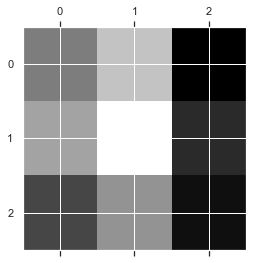

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
InputDataa = np.array(InputData)
OutputDataa = np.array(OutputData)
Output_Preda = np.array(Output_Pred)

In [47]:
AllResults = pd.DataFrame(InputData)
AllResults["Output"]= OutputDataa
AllResults["Output_pred"]= Output_Preda

AllResults.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,Output,Output_pred
9722,0.006695,0.005661,0.004903,0.102701,0.503146,0.003499,0.225971,0.002938,0.002720,0.031374,...,0.001203,0.078049,0.001129,0.001095,0.001063,2,17,5,1,2
9981,0.008524,0.007204,0.006241,0.005505,0.004924,0.404318,0.004066,0.003740,0.003462,0.003223,...,0.001531,0.001482,0.001437,0.001394,0.392324,61,197,5,1,0
7355,0.009372,0.007925,0.006865,0.006055,0.005416,0.004899,0.004472,0.004114,0.003809,0.003546,...,0.001684,0.001631,0.001580,0.001533,0.519137,2,8,1,1,1
9058,0.008520,0.662140,0.006241,0.005505,0.004924,0.004454,0.004066,0.003740,0.003462,0.003223,...,0.001531,0.001482,0.001437,0.001394,0.001353,11,0,5,1,1
13385,0.554280,0.007204,0.006241,0.005505,0.004924,0.004454,0.004066,0.003740,0.003462,0.007392,...,0.001531,0.001482,0.001437,0.001394,0.001353,18,94,11,0,0


In [48]:
ResultCorr = np.array(AllResults.corr())
AllResults.corr()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,Output,Output_pred
0,1.000000,-0.043164,-0.052448,-0.037967,-0.054500,-0.036000,-0.042866,-0.036289,-0.046577,-0.075360,...,-0.037901,-0.044708,-0.044647,-0.049334,-0.034198,-0.000107,0.004199,0.021576,0.010343,0.032363
1,-0.043164,1.000000,-0.037409,-0.040881,-0.052867,-0.042192,-0.033971,-0.032887,-0.035839,-0.065072,...,-0.036598,-0.038883,-0.043255,-0.047599,-0.011386,-0.016116,-0.029683,0.003491,-0.013489,-0.031772
2,-0.052448,-0.037409,1.000000,-0.049299,-0.060970,-0.054010,-0.046042,-0.048734,-0.043075,-0.080683,...,-0.034691,-0.051379,-0.052050,-0.050274,-0.035123,-0.022206,-0.018968,0.035784,-0.023700,-0.061673
3,-0.037967,-0.040881,-0.049299,1.000000,-0.033622,-0.035633,-0.025480,-0.036953,-0.035147,-0.075213,...,-0.023458,-0.037603,-0.033004,-0.030938,-0.030537,0.019448,0.014381,-0.010013,-0.019596,-0.057108
4,-0.054500,-0.052867,-0.060970,-0.033622,1.000000,-0.032922,-0.047015,-0.042319,-0.037679,-0.069741,...,-0.030356,-0.031530,-0.022075,0.007633,-0.041959,0.054851,0.069787,-0.036456,0.006871,-0.011980
5,-0.036000,-0.042192,-0.054010,-0.035633,-0.032922,1.000000,-0.036248,-0.038841,-0.035606,-0.057990,...,-0.026767,-0.022793,-0.028165,-0.035672,-0.030203,0.008275,0.017713,-0.017694,0.000250,0.033854
6,-0.042866,-0.033971,-0.046042,-0.025480,-0.047015,-0.036248,1.000000,-0.029929,-0.028387,-0.080963,...,-0.020897,-0.041646,-0.034806,-0.048369,-0.025969,-0.000356,0.001331,-0.012015,-0.021367,-0.082015
7,-0.036289,-0.032887,-0.048734,-0.036953,-0.042319,-0.038841,-0.029929,1.000000,-0.033736,-0.056096,...,-0.030446,-0.032234,-0.035508,-0.041172,-0.032973,-0.000185,0.000875,0.033053,-0.001331,-0.011048
8,-0.046577,-0.035839,-0.043075,-0.035147,-0.037679,-0.035606,-0.028387,-0.033736,1.000000,-0.039802,...,-0.020697,-0.024724,-0.030174,-0.031202,-0.031577,0.018096,0.015173,-0.050864,-0.012441,-0.073277
9,-0.075360,-0.065072,-0.080683,-0.075213,-0.069741,-0.057990,-0.080963,-0.056096,-0.039802,1.000000,...,-0.065434,-0.038798,-0.069858,-0.069841,-0.067414,-0.035702,-0.032356,0.058316,0.022245,0.079319


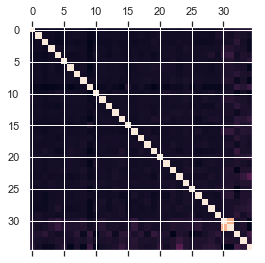

In [49]:
plt.matshow(ResultCorr)
plt.show()

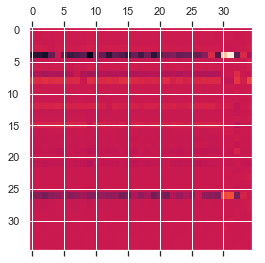

In [50]:
row_sums = ResultCorr.sum(axis=1, keepdims=True)
norm_corr = ResultCorr / row_sums
np.fill_diagonal(norm_corr, 0.005)

plt.matshow(norm_corr)
plt.show()